# Test MH harmonic

In [1]:
import os, sys, time
import argparse
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.random as random
import toml
import numpyro
from functools import partial
import micmac
from micmac import *
from fgbuster.observation_helpers import *

from jax import config
current_path = os.path.abspath('')
sys.path.append(current_path)
sys.path.append(os.path.dirname(os.path.dirname(current_path))+'/tutorials/')

config.update("jax_enable_x64", True)

In [2]:
path_home_test_playground = os.path.dirname(current_path) + '/'

In [3]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'
directory_additional_params = working_directory_path + 'additional_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


In [4]:
num_jobs = 5

file_ver = 'corr_fullsky_LB_v104_v2a_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_LB_v2a.toml'
## Not converged at all

file_ver = 'corr_fullsky_LB_v104_v2b_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_LB_v2b.toml'
## Also not converged at all

file_ver = 'corr_fullsky_v104_v1a_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_v1a.toml'
## r seems to have converged, but not all chains agree, at least 1/5 is a bit further than the rest, 
## and the 4 others agree up to delta_r = 10^-4
## Still bit unclear for B_f, need to test Gelman-Rubin, with harmonic, and verify all input maps are the same
## wrong run, should be with r=0 not r=0.01

file_ver = 'corr_fullsky_v104_v1b_gpu_{}_{}'
path_additional_params = directory_additional_params + 'add_gpu_corr_fullsky_v1b.toml'
## r seems to have converged, but not all chains agree, at least 1/5 is a bit further than the rest, 
## and the 4 others agree up to delta_r = 10^-4
## Still bit unclear for B_f, need to test Gelman-Rubin, with harmonic, and verify all input maps are the same


In [5]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

reduction_noise = dictionary_additional_parameters['reduction_noise']
# factor_Fisher = dictionary_additional_parameters['factor_Fisher']
# relative_treshold = dictionary_additional_parameters['relative_treshold']
# sigma_gap = dictionary_additional_parameters['sigma_gap']
fgs_model = dictionary_additional_parameters['fgs_model']
# initial_guess_r = dictionary_additional_parameters['initial_guess_r']
# use_nhits = dictionary_additional_parameters['use_nhits']
# name_mask = dictionary_additional_parameters['name_mask']
# use_mask = dictionary_additional_parameters['use_mask']
name_toml = dictionary_additional_parameters['name_toml']
seed_realization_input = dictionary_additional_parameters['seed_realization_input']

print("Using toml file: ", name_toml)

Using toml file:  corr_fullsky_v1b.toml


In [6]:
path_toml_file = directory_toml_file + name_toml

In [7]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

if 'corr_fullsky_v104_v1a_gpu_' in file_ver:
    MICMAC_sampler_obj.r_true = 0.01

In [8]:
fgs_model_ = 'd0s0'
instr_name = MICMAC_sampler_obj.instrument_name #'SO_SAT'

path_Fisher = path_home_test_playground + f'Fisher_matrix_{MICMAC_sampler_obj.instrument_name}_EB_model_{fgs_model_}_noise_True_seed_42_lmin2_lmax128.txt'
try :
    Fisher_matrix = np.loadtxt(path_Fisher)
except:
    print("Fisher matrix not found !", flush=True)
    Fisher_matrix = np.loadtxt(path_home_test_playground + f'Fisher_matrix_{MICMAC_sampler_obj.instrument_name}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')


In [9]:
# get instrument from public database
instrument = get_instrument(instr_name)
depth_p_array = np.array(instrument['depth_p'])/dictionary_additional_parameters['reduction_noise']

In [10]:
covariance_B_f_to_use = np.linalg.inv(Fisher_matrix)[:-1, :-1]

MICMAC_Harm_obj = create_Harmonic_MICMAC_sampler_from_MICMAC_sampler_obj(MICMAC_sampler_obj, depth_p_array,
                                                    covariance_B_f=covariance_B_f_to_use)

MICMAC_Harm_obj.step_size_r = np.sqrt(np.linalg.inv(Fisher_matrix)[-1, -1])

In [11]:
NSIDE = MICMAC_Harm_obj.nside

noise_seed = MICMAC_Harm_obj.seed
# instr_name = MICMAC_Harm_obj.instrument_name

# # get instrument from public database
# instrument = get_instrument(instr_name)

# get input freq maps
np.random.seed(noise_seed)

freq_maps_fgs = get_observation(instrument, fgs_model, nside=NSIDE, noise=True)[:, 1:, :]   # keep only Q and U

_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_Harm_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_Harm_obj.nstokes]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Calculating spectra from CAMB !
Calculating spectra from CAMB !


## Retrieving input map

In [12]:
initial_freq_maps = []
input_cmb_maps = []
MICMAC_all_r_samples = []
MICMAC_all_params_mixing_matrix_samples = []

for job in range(num_jobs):
    initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))

    if MICMAC_sampler_obj.sample_r_Metropolis:
        all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        MICMAC_all_r_samples.append(np.load(all_r_samples_path))

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    MICMAC_all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
if MICMAC_sampler_obj.sample_r_Metropolis:
    MICMAC_all_r_samples = np.array(MICMAC_all_r_samples)
MICMAC_all_params_mixing_matrix_samples = np.array(MICMAC_all_params_mixing_matrix_samples)

In [13]:
input_freq_maps = initial_freq_maps[0]

In [14]:
for i in range(initial_freq_maps.shape[0]):
    print(initial_freq_maps[0][initial_freq_maps[i]-initial_freq_maps[0]!=0])

[]
[]
[]
[]
[]


In [15]:
# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_Harm_obj.number_components, pos_special_freqs=MICMAC_Harm_obj.pos_special_freqs)

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_Harm_obj.number_components, init_params, pos_special_freqs=MICMAC_Harm_obj.pos_special_freqs)
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)



In [16]:
theoretical_r0_total = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)

c_ell_approx = np.zeros((3,MICMAC_Harm_obj.lmax+1))
c_ell_approx[0,MICMAC_Harm_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_Harm_obj.lmin:] = theoretical_r0_total[1,:]

red_cov_approx_matrix = get_reduced_matrix_from_c_ell_jax(c_ell_approx)[MICMAC_Harm_obj.lmin:]

In [17]:
final_values_params_mixing_matrix = MICMAC_all_params_mixing_matrix_samples.mean(axis=(0,1)).ravel(order='F')
final_values_r = MICMAC_all_r_samples.mean()

## Starting MH

In [18]:
dimension_free_param_B_f = 2*(MICMAC_Harm_obj.number_frequencies-len_pos_special_freqs)

In [19]:
first_guess = final_values_params_mixing_matrix.ravel(order='F')
first_guess_r = final_values_r

In [20]:
MICMAC_Harm_obj.number_iterations_sampling = 10000

In [21]:
MICMAC_Harm_obj.perform_harmonic_MH(input_freq_maps, c_ell_approx, first_guess, initial_guess_r=first_guess_r,
                                    covariance_B_f_r=None, theoretical_r0_total=theoretical_r0_total, theoretical_r1_tensor=theoretical_r1_tensor)

Disabling chex !!!
Covariance B_f, r [[ 1.57489654e-08  2.71276909e-09  2.36835419e-09  1.51939102e-09
  -3.07091465e-09 -2.22079266e-10 -1.71572069e-10 -1.08678732e-10
   0.00000000e+00]
 [ 2.71276909e-09  3.60992230e-09  3.23728759e-09  2.20123320e-09
  -2.22092335e-10 -2.67787336e-10 -2.20384248e-10 -1.65635733e-10
   0.00000000e+00]
 [ 2.36835419e-09  3.23728759e-09  3.35867742e-09  2.28038258e-09
  -1.71583988e-10 -2.20383790e-10 -2.75123127e-10 -2.01145001e-10
   0.00000000e+00]
 [ 1.51939102e-09  2.20123320e-09  2.28038258e-09  3.39944797e-09
  -1.08682729e-10 -1.65630220e-10 -2.01140112e-10 -5.35936148e-10
   0.00000000e+00]
 [-3.07091465e-09 -2.22092335e-10 -1.71583988e-10 -1.08682729e-10
   2.22105731e-09  3.30205693e-10  2.84475588e-10  1.82264589e-10
   0.00000000e+00]
 [-2.22079266e-10 -2.67787336e-10 -2.20383790e-10 -1.65630220e-10
   3.30205693e-10  4.34708081e-10  3.86465385e-10  2.65474299e-10
   0.00000000e+00]
 [-1.71572069e-10 -2.20384248e-10 -2.75123127e-10 -2.0114

sample: 100%|██████████| 10000/10000 [06:52<00:00, 24.26it/s]

End of MH iterations for harmonic run in 6.872116367022197 minutes, now saving results !
Test [[0.33909206 0.03004359 0.01040528 ... 0.12912109 0.44078566 0.01065332]
 [0.33906155 0.03000045 0.01031885 ... 0.1291508  0.44079757 0.01180895]
 [0.33901758 0.02993425 0.0102293  ... 0.12915638 0.44082591 0.01166963]
 ...
 [0.33856736 0.02965509 0.01000384 ... 0.12912034 0.44074876 0.00999361]
 [0.33856736 0.02965509 0.01000384 ... 0.12912034 0.44074876 0.00999361]
 [0.33856736 0.02965509 0.01000384 ... 0.12912034 0.44074876 0.00999361]]
Test size (10000, 9)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.34      0.00      0.34      0.34      0.34    384.38      1.00
Param:0[1]      0.03      0.00      0.03      0.03      0.03    330.77      1.00
Param:0[2]      0.01      0.00      0.01      0.01      0.01    339.09      1.00
Param:0[3]      0.00      0.00      0.00      0.00      0.00    379.52      1.00
Param:0[4]      0.01      0.00      0.01      0.01      0.01    383.72      1.00
Param:0[5]      0.05      0.00      0.05      0.05      0.05    308.37      1.00
Param:0[6]      0.13      0.00      0.13      0.13      0.13    350.06      1.00
Param:0[7]      0.44      0.00      0.44      0.44      0.44    366.53      1.00
Param:0[8]      0.01      0.00      0.01      0.01      0.01    313.43      1.00



In [22]:
MICMAC_Harm_obj.all_samples_r.shape

(10000,)

In [23]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.shape

(10000, 4, 2)

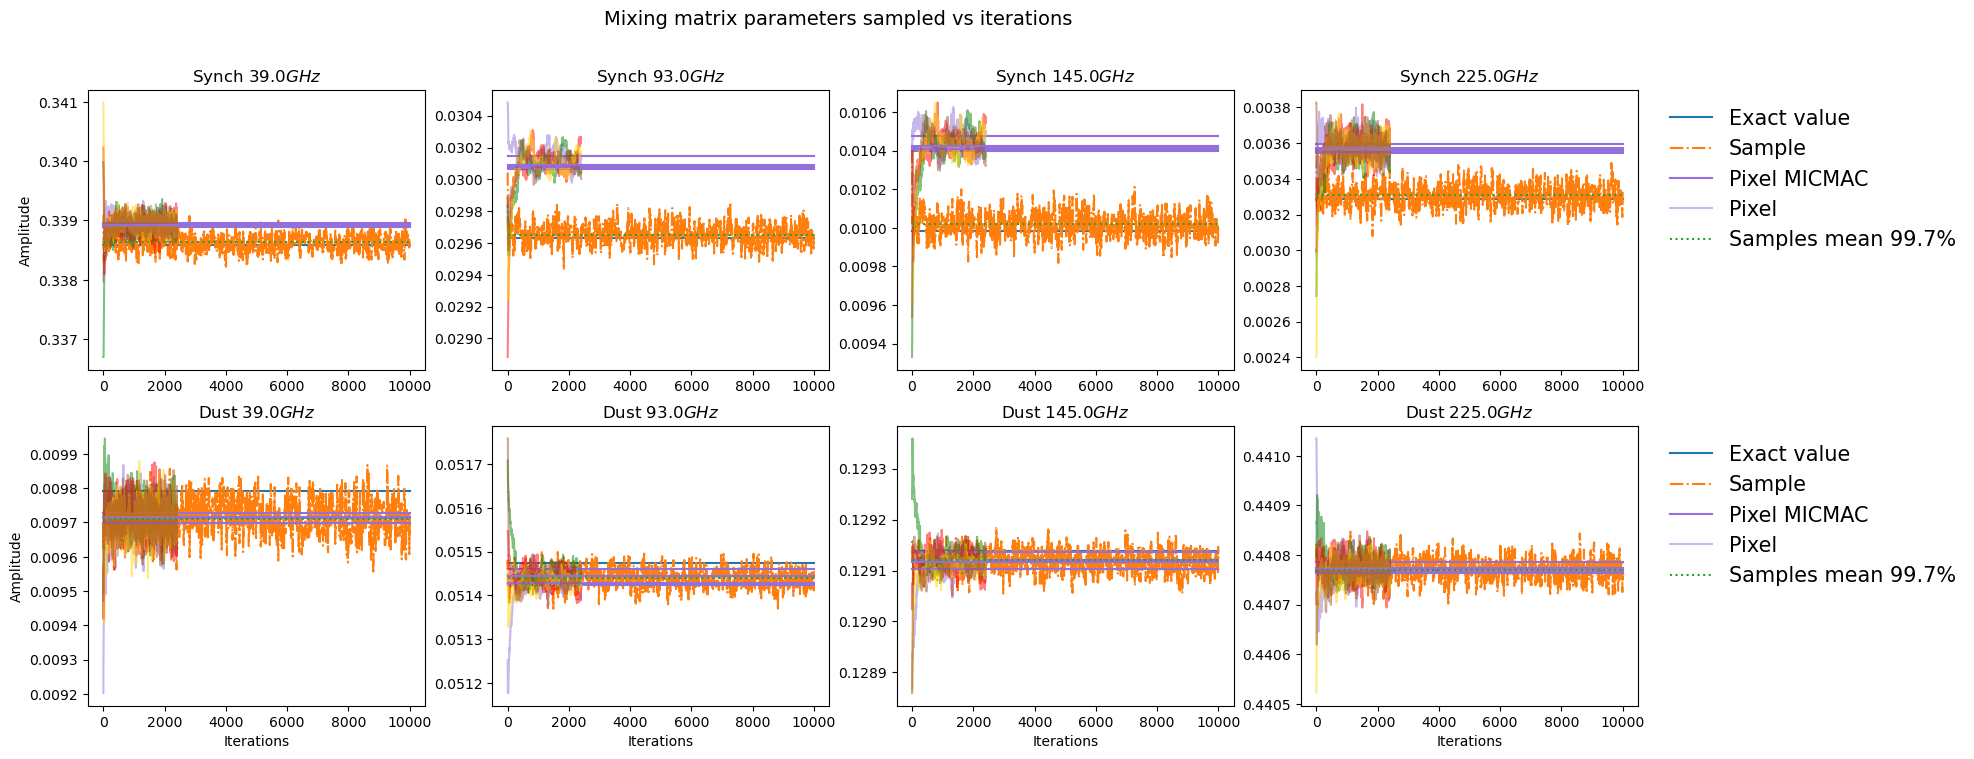

In [24]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

all_B_f_sample_synch = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = MICMAC_Harm_obj.all_params_mixing_matrix_samples[:,:,1]

MICMAC_B_f_sample_synch = MICMAC_all_params_mixing_matrix_samples[...,0]
MICMAC_B_f_sample_dust = MICMAC_all_params_mixing_matrix_samples[...,1]
final_MICMAC_pixel_B_f_synch = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,0]
final_MICMAC_pixel_B_f_dust = MICMAC_all_params_mixing_matrix_samples.mean(axis=1)[...,1]

frequency_array = np.array(instrument['frequency'])

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'green', 'red', 'gold', 'sienna']

if MICMAC_Harm_obj.number_frequencies-len_pos_special_freqs < 10:
    plt.figure(figsize=(20,8))
    plt.suptitle('Mixing matrix parameters sampled vs iterations', fontsize=14)
    # plt.subplot(121)

    for i in range(MICMAC_Harm_obj.number_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i,0],init_params[i,0]], label='Exact value')
        plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample')

        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[0,i],final_MICMAC_pixel_B_f_synch[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value, label='Pixel')
        for j in range(1,MICMAC_B_f_sample_synch.shape[0]):
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_synch[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
            plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_synch[j,i],final_MICMAC_pixel_B_f_synch[j,i]], color=color_MICMAC_pixel)
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_synch[:,i].mean()
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

        # plt.yscale('log')
        # plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    # plt.figure(figsize=(20,8))
    # plt.subplot(122)
    for i in range(MICMAC_Harm_obj.number_frequencies-len_pos_special_freqs):
        plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
        # plt.subplot(201+len(frequency_Bf)*10+i)
        plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [init_params[i,1],init_params[i,1]], label='Exact value')
        plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample')

        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[0,i],final_MICMAC_pixel_B_f_dust[0,i]], color=color_MICMAC_pixel, label='Pixel MICMAC')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[0,:,i], color=color_MICMAC_pixel_list[0], alpha=alpha_value,label='Pixel')
        for j in range(1,MICMAC_B_f_sample_dust.shape[0]):
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_B_f_sample_dust[j,:,i], color=color_MICMAC_pixel_list[j], alpha=alpha_value)
            plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_B_f_dust[j,i],final_MICMAC_pixel_B_f_dust[j,i]], color=color_MICMAC_pixel)
        
        n_sigma = 3
        transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
        cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
        mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
        std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

        mean_value = all_B_f_sample_dust[:,i].mean()
        plt.plot([0,MICMAC_Harm_obj.number_iterations_sampling], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
        # plt.yscale('log')
        plt.xlabel('Iterations')
        if i == 0:
            plt.ylabel('Amplitude')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    # plt.loglog()

    plt.show()

(4999,) 10000


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


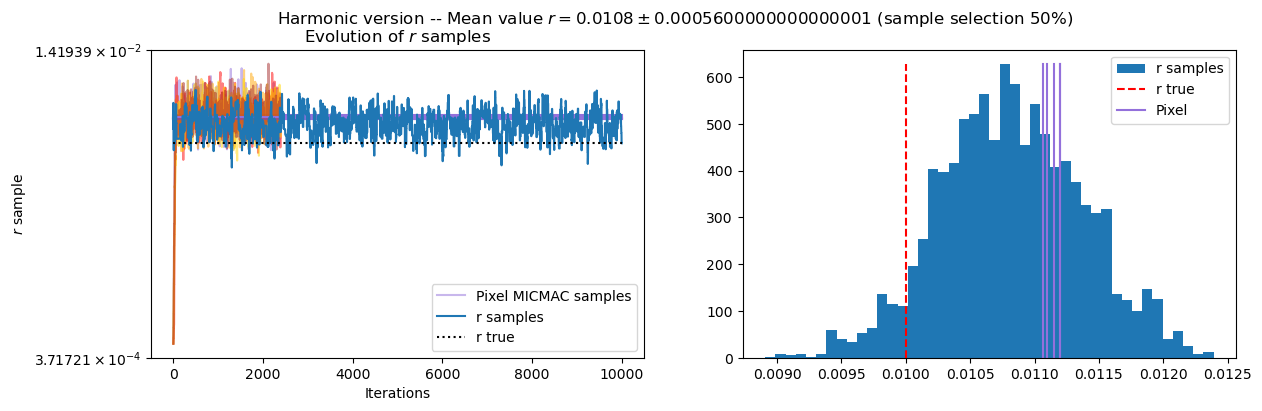

In [25]:
plt.figure(figsize=(14,4))

n_sigma = 3

all_r_samples = MICMAC_Harm_obj.all_samples_r

burn_in_iterations = MICMAC_Harm_obj.number_iterations_sampling//2
# cond = np.abs((all_r_samples - all_r_samples.mean())/(all_r_samples.std())) < n_sigma
cond = np.arange(MICMAC_Harm_obj.number_iterations_sampling) > burn_in_iterations
print(all_r_samples[cond].shape, MICMAC_Harm_obj.number_iterations_sampling)
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)

alpha_value = .5
color_MICMAC_pixel = 'mediumpurple'
color_MICMAC_pixel_list = ['mediumpurple', 'orange', 'red', 'gold', 'brown']

plt.suptitle(f"Harmonic version -- Mean value $r = {mean_r} \pm {std_r}$ (sample selection 50%) ")

final_MICMAC_pixel_r = MICMAC_all_r_samples.mean(axis=1)

plt.subplot(121)

plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_all_r_samples[0], color=color_MICMAC_pixel_list[0], label='Pixel MICMAC samples', alpha=alpha_value)
plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_r[0],final_MICMAC_pixel_r[0]], color=color_MICMAC_pixel)
for i in range(1,MICMAC_all_r_samples.shape[0]):
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), MICMAC_all_r_samples[i], color=color_MICMAC_pixel_list[i], alpha=alpha_value)

    plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], color=color_MICMAC_pixel)

plt.plot(np.arange(MICMAC_Harm_obj.number_iterations_sampling), all_r_samples, label='r samples')
plt.plot([0, MICMAC_Harm_obj.number_iterations_sampling], [MICMAC_Harm_obj.r_true,MICMAC_Harm_obj.r_true], 'k:', label='r true')


plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title(r'Evolution of $r$ samples')
plt.yscale('symlog')
plt.legend()

plt.subplot(122)
hist_values, bins_value, _ = plt.hist(all_r_samples, bins='rice', label='r samples')
plt.plot([MICMAC_Harm_obj.r_true,MICMAC_Harm_obj.r_true], [0,hist_values.max()], 'r--', label='r true')

plt.plot([final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], [0,hist_values.max()], color=color_MICMAC_pixel, label='Pixel')
for i in range(1, MICMAC_all_r_samples.shape[0]):
    plt.plot([final_MICMAC_pixel_r[i],final_MICMAC_pixel_r[i]], [0,hist_values.max()], color=color_MICMAC_pixel)
    
plt.legend()
plt.show()

In [26]:
all_r_samples.shape

(10000,)

In [39]:
jnp.cov(jnp.expand_dims(all_r_samples,axis=0), rowvar=True)

Array(3.0653076e-07, dtype=float64)

In [28]:
all_r_samples.var()

Array(3.06500107e-07, dtype=float64)

In [40]:
(jnp.sum(all_r_samples*all_r_samples) - all_r_samples.shape[0]*(all_r_samples.mean())**2)/(all_r_samples.shape[0]-1)

Array(3.0653076e-07, dtype=float64)

In [42]:
MICMAC_Harm_obj.all_params_mixing_matrix_samples.shape

(10000, 4, 2)

In [49]:
all_samples_B_f_r = np.zeros((MICMAC_Harm_obj.number_iterations_sampling, (MICMAC_Harm_obj.number_frequencies-len_pos_special_freqs)*2+1))

all_samples_B_f_r[:,-1] = all_r_samples
all_samples_B_f_r[:,:-1] = MICMAC_Harm_obj.all_params_mixing_matrix_samples.reshape((MICMAC_Harm_obj.number_iterations_sampling, (MICMAC_Harm_obj.number_frequencies-len_pos_special_freqs)*2))

In [60]:
jnp.cov(all_samples_B_f_r, rowvar=False) - jnp.cov(all_samples_B_f_r.T)

Array([[ 3.30872245e-24,  4.96308368e-24,  1.65436123e-24,
         2.06795153e-25, -8.27180613e-25,  3.61891518e-25,
        -2.06795153e-25, -1.29246971e-25,  4.96308368e-24],
       [ 4.96308368e-24,  0.00000000e+00,  0.00000000e+00,
        -3.10192730e-25,  2.58493941e-26,  0.00000000e+00,
        -2.32644547e-25,  0.00000000e+00,  0.00000000e+00],
       [ 1.65436123e-24,  0.00000000e+00,  0.00000000e+00,
        -1.03397577e-25,  1.24077092e-24,  0.00000000e+00,
        -4.13590306e-25,  0.00000000e+00,  0.00000000e+00],
       [ 2.06795153e-25, -3.10192730e-25, -1.03397577e-25,
         2.58493941e-25, -3.10192730e-25, -1.03397577e-25,
        -7.75481824e-26,  0.00000000e+00,  3.61891518e-25],
       [-8.27180613e-25,  2.58493941e-26,  1.24077092e-24,
        -3.10192730e-25,  2.06795153e-24, -5.16987883e-26,
        -4.13590306e-25,  0.00000000e+00,  2.68833699e-24],
       [ 3.61891518e-25,  0.00000000e+00,  0.00000000e+00,
        -1.03397577e-25, -5.16987883e-26,  0.000000

In [53]:
np.diag(sp.linalg.sqrtm(jnp.cov(all_samples_B_f_r.T)))

array([1.27148187e-04, 4.27731811e-05, 4.77463757e-05, 1.63352777e-05,
       4.49126235e-05, 1.52586248e-05, 5.36219687e-05, 1.83646129e-05,
       5.53602802e-04])

In [58]:
np.diag(sp.linalg.sqrtm(np.linalg.pinv(np.loadtxt(path_Fisher))))

array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04])